# Exploración de datos
### Security Data Science -- Laboratorio 3
#### Adrian Rodriguez 21619
#### Jose Daniel Gomez Cabrera 21429

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.calibration import LabelEncoder
from sklearn.decomposition import TruncatedSVD

In [22]:
import google.generativeai as genai
from dotenv import load_dotenv
from tqdm.auto import tqdm
tqdm.pandas()
from google.api_core import retry

import os

load_dotenv()

genai.configure(api_key=os.getenv("GEMINI_API_KEY"))

#### Preprocesamiento

In [28]:
def create_api_sequences(dataframe):
    sequences = []
    labels = []

    for i in range(dataframe.shape[0]):
        apis = dataframe.iloc[i, 2:].dropna().tolist()
        api_sequence = ' '.join(apis)
        sequences.append(api_sequence)
        labels.append(dataframe.iloc[i, 1])

    return pd.Series(sequences), pd.Series(labels)

In [29]:
df = pd.read_csv('./data/MalBehavD-V1-dataset.csv')


In [30]:
api_sequences, labels = create_api_sequences(df)

In [32]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

#### Embedding

In [33]:
@retry.Retry(timeout=300.0) 
def embedding_fn(text: str):
    embedding = genai.embed_content(model="models/embedding-001",content=text, task_type="classification")
    return embedding['embedding']

df['embeddings'] = api_sequences.progress_apply(embedding_fn)


  0%|          | 0/2570 [00:00<?, ?it/s]

#### Split de Datos

In [35]:

embeddings_array = np.stack(df['embeddings'].values)
X_train, X_test, y_train, y_test = train_test_split(embeddings_array, encoded_labels, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_embeddings = scaler.fit_transform(X_train)
X_test_embeddings = scaler.transform(X_test)

Semilla para poder reproducir los resultados

In [36]:
np.random.seed(42)
tf.random.set_seed(42)

Modelo de red neuronal

In [37]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_embeddings.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

/Users/adrian/.pyenv/versions/3.10.14/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compilar modelo de NN

In [38]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

Resumen del modelo

In [39]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,329 (200.50 KB)

 Trainable params: 51,329 (200.50 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamos la red neuronal

In [40]:
history = model.fit(
    X_train_embeddings, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8029 - loss: 0.4395 - precision: 0.7983 - recall: 0.7925 - val_accuracy: 0.9056 - val_loss: 0.2060 - val_precision: 0.8878 - val_recall: 0.9355
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9260 - loss: 0.1976 - precision: 0.9286 - recall: 0.9164 - val_accuracy: 0.9361 - val_loss: 0.1654 - val_precision: 0.9358 - val_recall: 0.9409
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9397 - loss: 0.1621 - precision: 0.9383 - recall: 0.9354 - val_accuracy: 0.9333 - val_loss: 0.1619 - val_precision: 0.9402 - val_recall: 0.9301
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9378 - loss: 0.1621 - precision: 0.9416 - recall: 0.9287 - val_accuracy: 0.9278 - val_loss: 0.1654 - val_precision: 0.9301 - val_recall: 0.9301
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9451 - loss: 0.1434 - precision: 0.9487 - recall: 0.9357 - val_accuracy: 0.9389 - val_loss: 0.1561 - val

Historial de entrenamiento

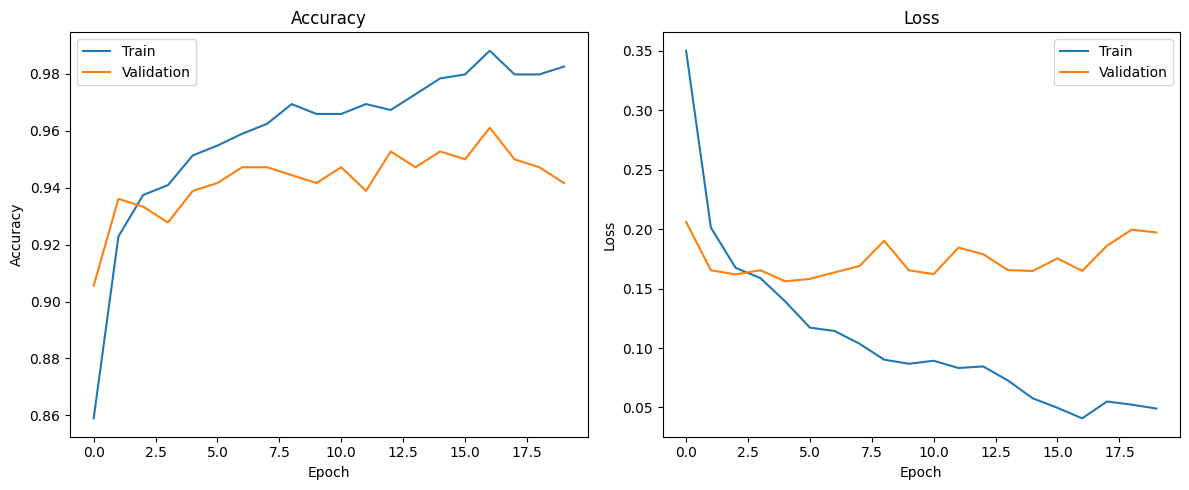

In [41]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('./model_results/training_history_model2.png')

Evaluar el modelo con el conjunto de prueba

In [42]:
y_pred_prob = model.predict(X_test_embeddings).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Metricas de evaluacion

In [43]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("\nEvaluación en el conjunto de prueba:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


Evaluación en el conjunto de prueba:
Accuracy: 0.9390
Precision: 0.9388
Recall: 0.9412
F1 Score: 0.9400
ROC AUC: 0.9775


Matriz de confusion

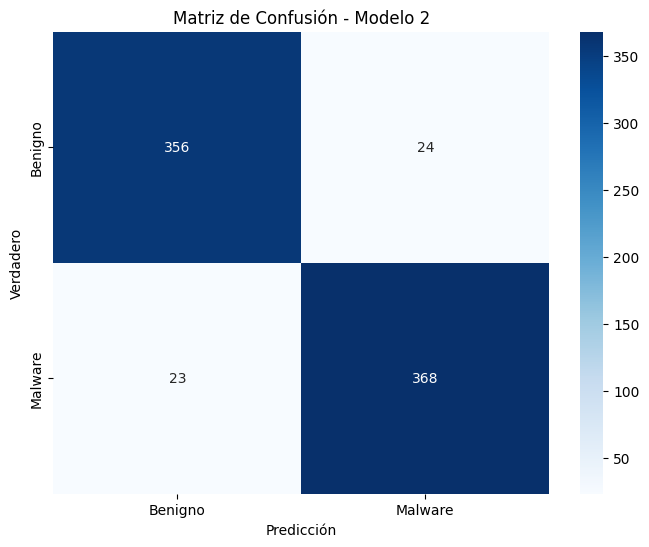

In [44]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benigno', 'Malware'],
            yticklabels=['Benigno', 'Malware'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión - Modelo 2')
plt.savefig('./model_results/confusion_matrix_model2.png')

Curvas de ROC

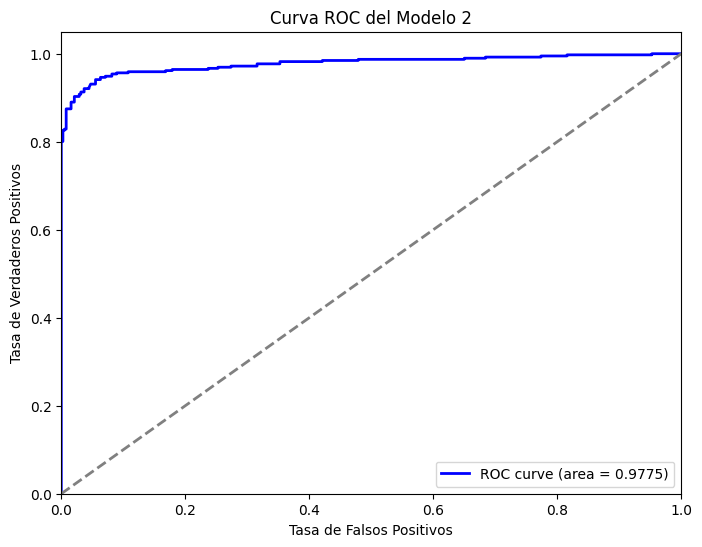

In [45]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC del Modelo 2')
plt.legend(loc='lower right')
plt.savefig('./model_results/roc_curve_model2.png')

Informe de clasificacion

In [46]:
print(classification_report(y_test, y_pred, target_names=['Benigno', 'Malware']))

              precision    recall  f1-score   support

     Benigno       0.94      0.94      0.94       380
     Malware       0.94      0.94      0.94       391

    accuracy                           0.94       771
   macro avg       0.94      0.94      0.94       771
weighted avg       0.94      0.94      0.94       771



Validacion cruzada con k = 10

In [47]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cv_accuracy = []
cv_precision = []
cv_recall = []
cv_f1 = []
cv_auc = []

for train_idx, val_idx in kfold.split(X_train_embeddings, y_train):
    # Datos de entrenamiento y validación para este fold
    X_fold_train, X_fold_val = X_train_embeddings[train_idx], X_train_embeddings[val_idx]
    y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

    # Crear y entrenar un nuevo modelo
    fold_model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_embeddings.shape[1],)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    fold_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo en silencio
    fold_model.fit(X_fold_train, y_fold_train, epochs=10, batch_size=32, verbose=0)

    # Predecir en la validación
    y_fold_pred_prob = fold_model.predict(X_fold_val, verbose=0).flatten()
    y_fold_pred = (y_fold_pred_prob > 0.5).astype(int)

    # Calcular métricas
    cv_accuracy.append(accuracy_score(y_fold_val, y_fold_pred))
    cv_precision.append(precision_score(y_fold_val, y_fold_pred))
    cv_recall.append(recall_score(y_fold_val, y_fold_pred))
    cv_f1.append(f1_score(y_fold_val, y_fold_pred))
    cv_auc.append(roc_auc_score(y_fold_val, y_fold_pred_prob))

# Mostrar resultados de la validación cruzada
print(f"CV Accuracy: {np.mean(cv_accuracy):.4f} (±{np.std(cv_accuracy):.4f})")
print(f"CV Precision: {np.mean(cv_precision):.4f} (±{np.std(cv_precision):.4f})")
print(f"CV Recall: {np.mean(cv_recall):.4f} (±{np.std(cv_recall):.4f})")
print(f"CV F1 Score: {np.mean(cv_f1):.4f} (±{np.std(cv_f1):.4f})")
print(f"CV ROC AUC: {np.mean(cv_auc):.4f} (±{np.std(cv_auc):.4f})")

/Users/adrian/.pyenv/versions/3.10.14/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/adrian/.pyenv/versions/3.10.14/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


/Users/adrian/.pyenv/versions/3.10.14/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


/Users/adrian/.pyenv/versions/3.10.14/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/adrian/.pyenv/versions/3.10.14/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/adrian/.pyenv/versions/3.10.14/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead

CV Accuracy: 0.9500 (±0.0139)
CV Precision: 0.9540 (±0.0199)
CV Recall: 0.9452 (±0.0146)
CV F1 Score: 0.9494 (±0.0140)
CV ROC AUC: 0.9834 (±0.0088)


Guardar modelo para comparar

In [48]:
model.save('./models/model2_nn_embeddings.h5')
# also save it as keras recomend, using native keras format
model.save('./models/model2_nn_embeddings.keras', save_format='tf')